In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import janitor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
# Cambiar directorio
os.chdir("..")

In [3]:
# Cargar los datos que tenemos disponibles
data = pd.read_csv("data/churn.csv")

In [4]:
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
# Nos deshacemos de las columnas que no contribuyen en mucho
data = data.drop(data.columns[0:3], axis=1)

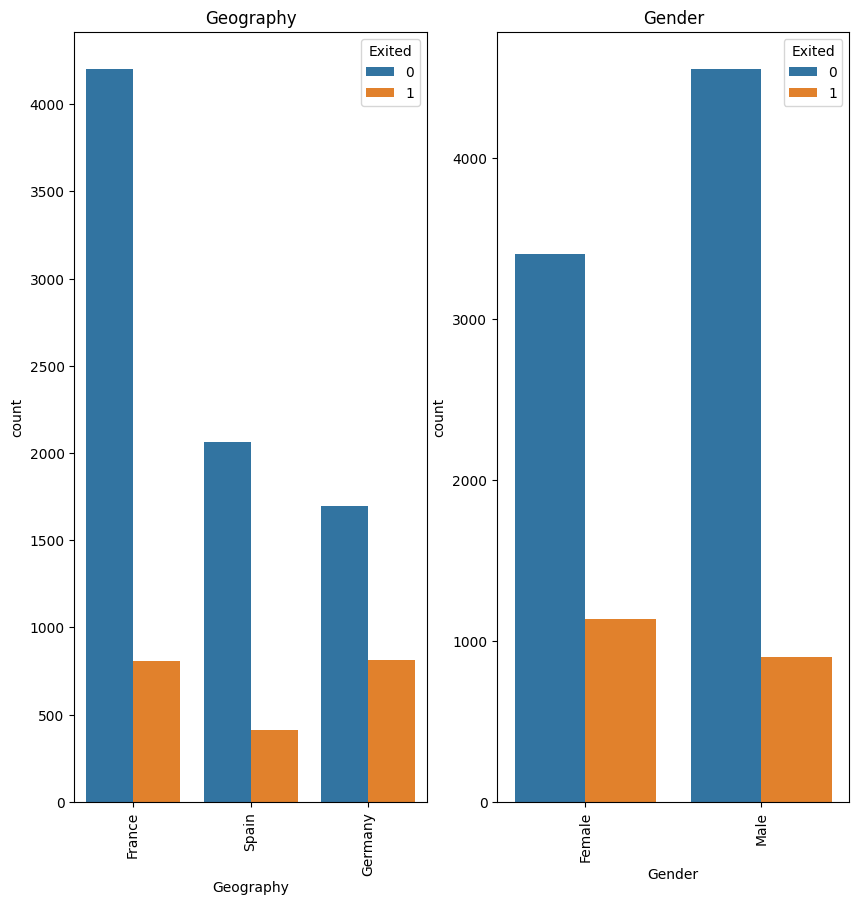

In [8]:
#Identificamos las columnas categóricas y graficamos la distribución de las mismas
cat_cols = data.select_dtypes(include='object').columns

fig, ax = plt.subplots(figsize=(10, 10), ncols=len(cat_cols), nrows=1)
for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=data, ax=ax[i], hue='Exited')
    ax[i].set_title(col)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)

/home/pipe-vash/Personal_Projects/ml_lab/laboratorio-machine-learning/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


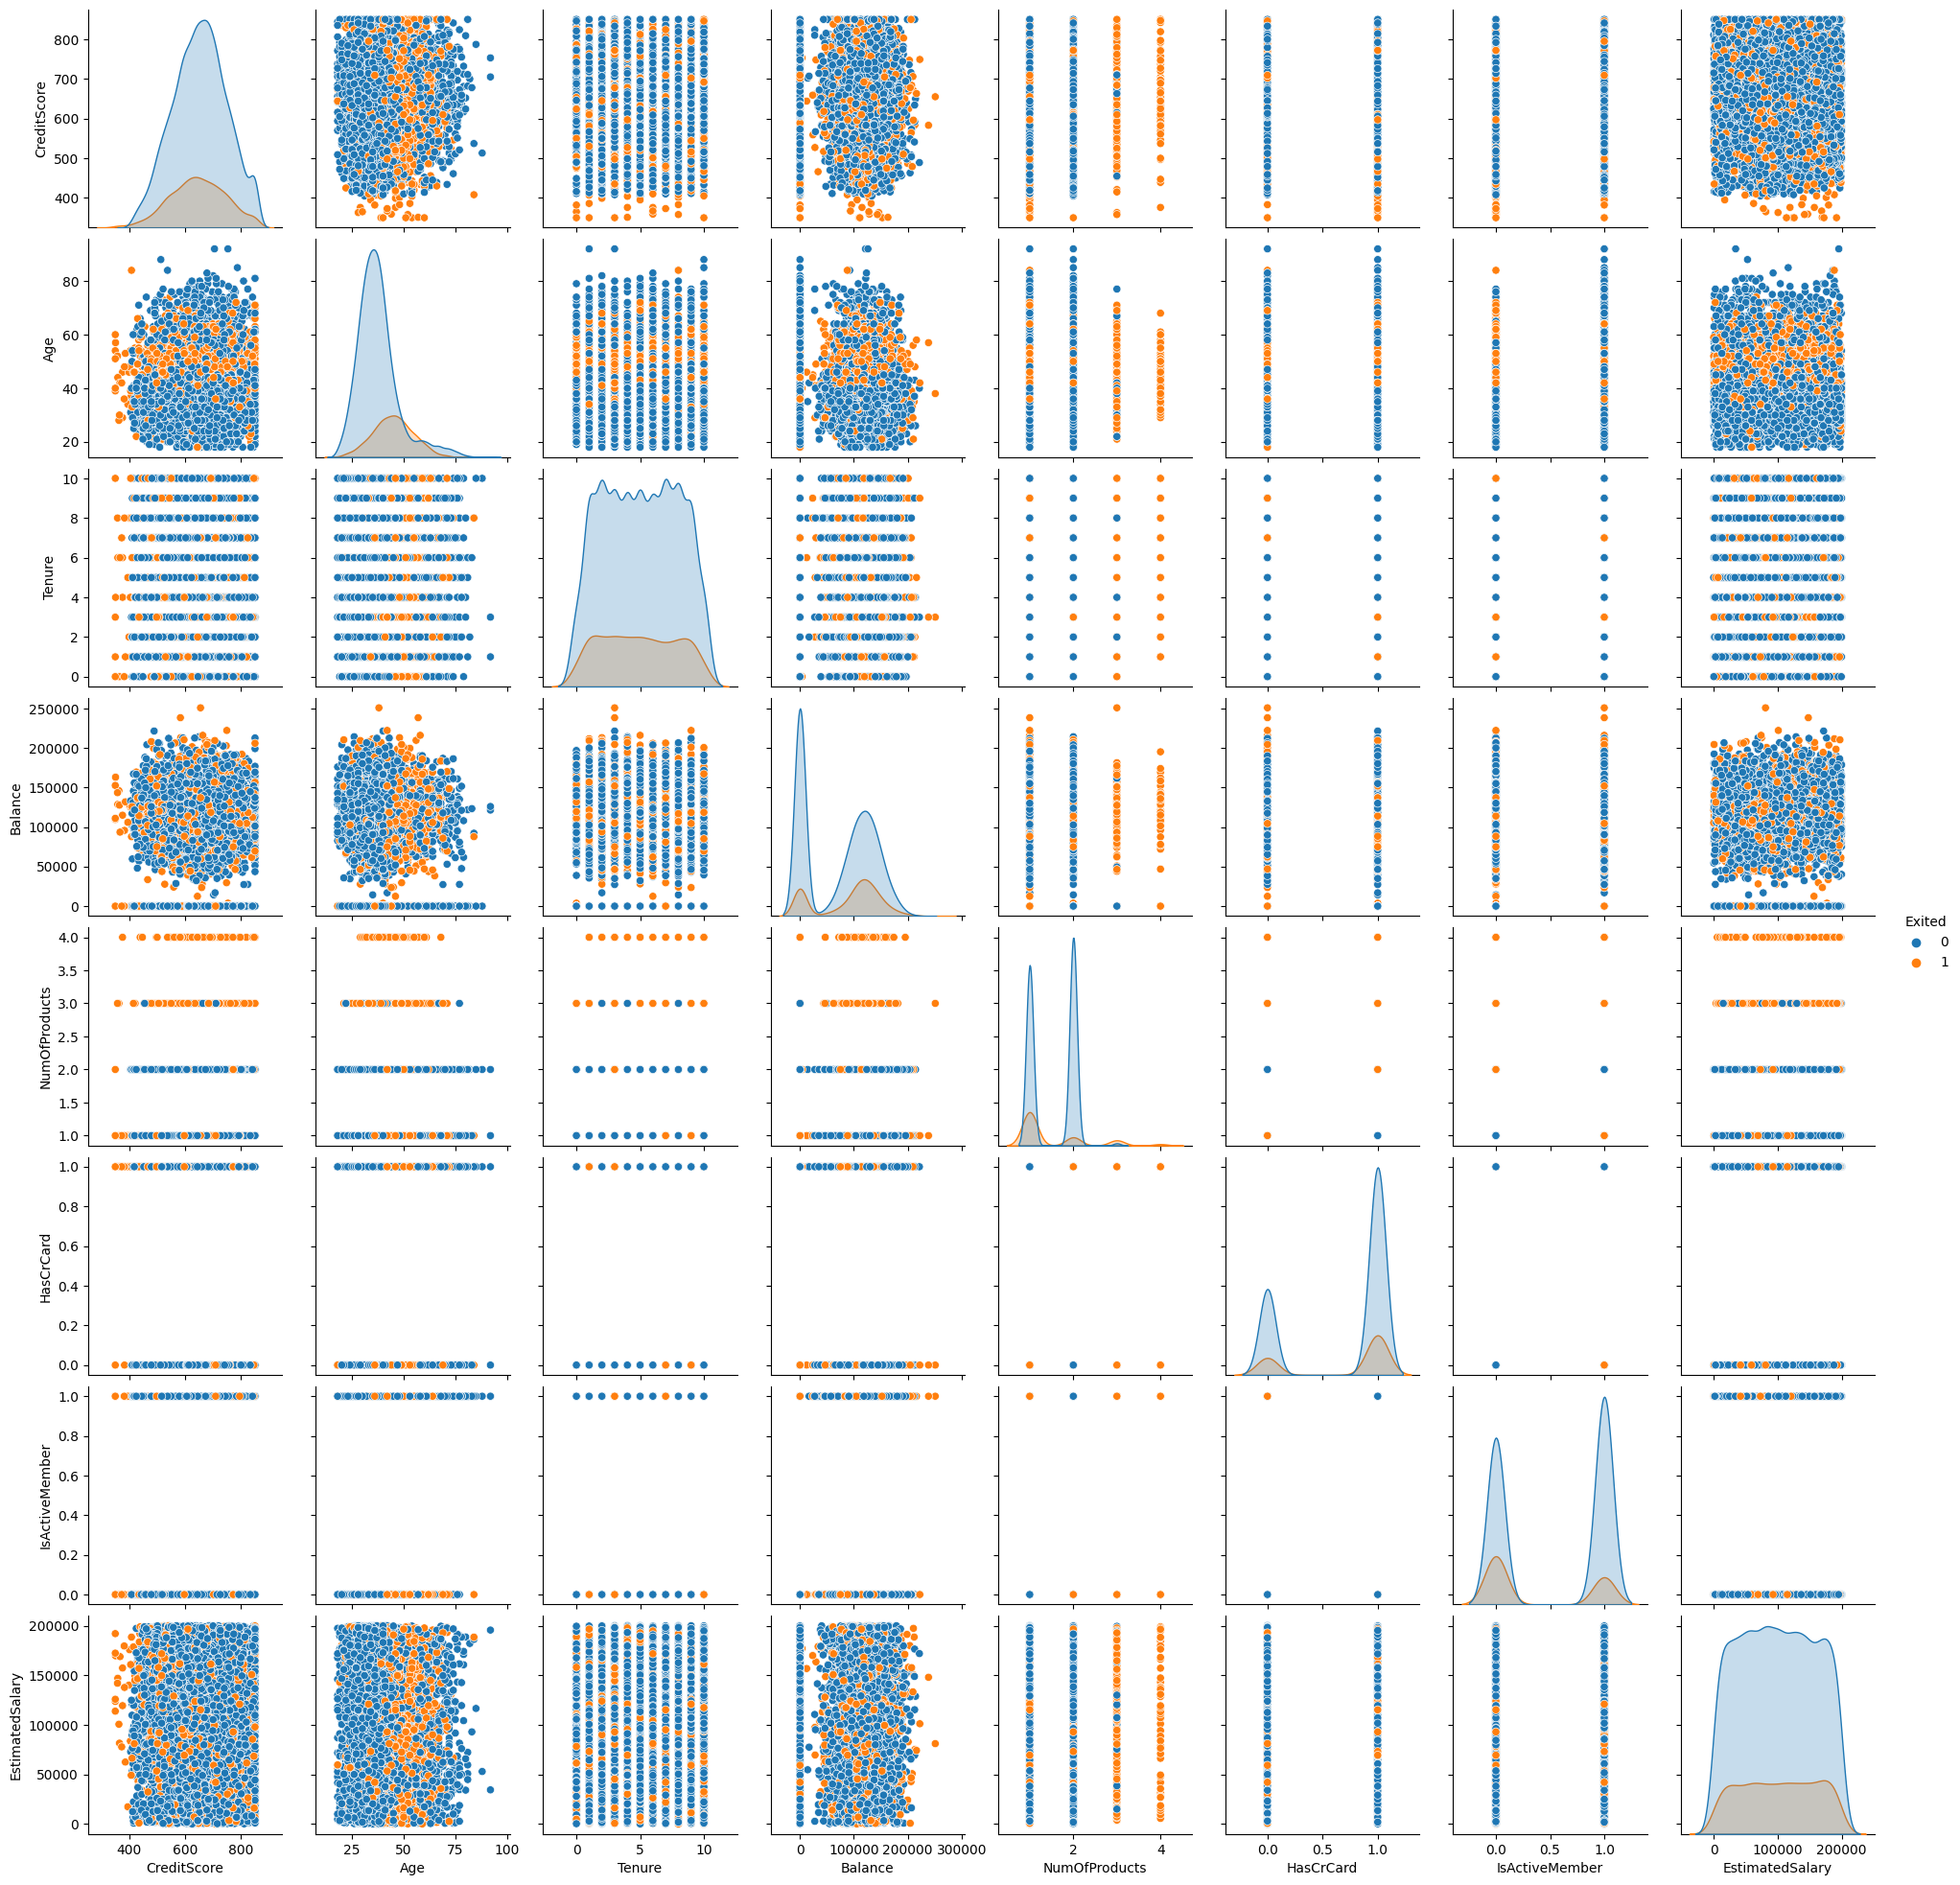

In [7]:
#Graficamos las variables numéricas separadas por el target para identificar potenciales comportamientos.
sns.pairplot(data, hue='Exited')

/home/pipe-vash/Personal_Projects/ml_lab/laboratorio-machine-learning/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


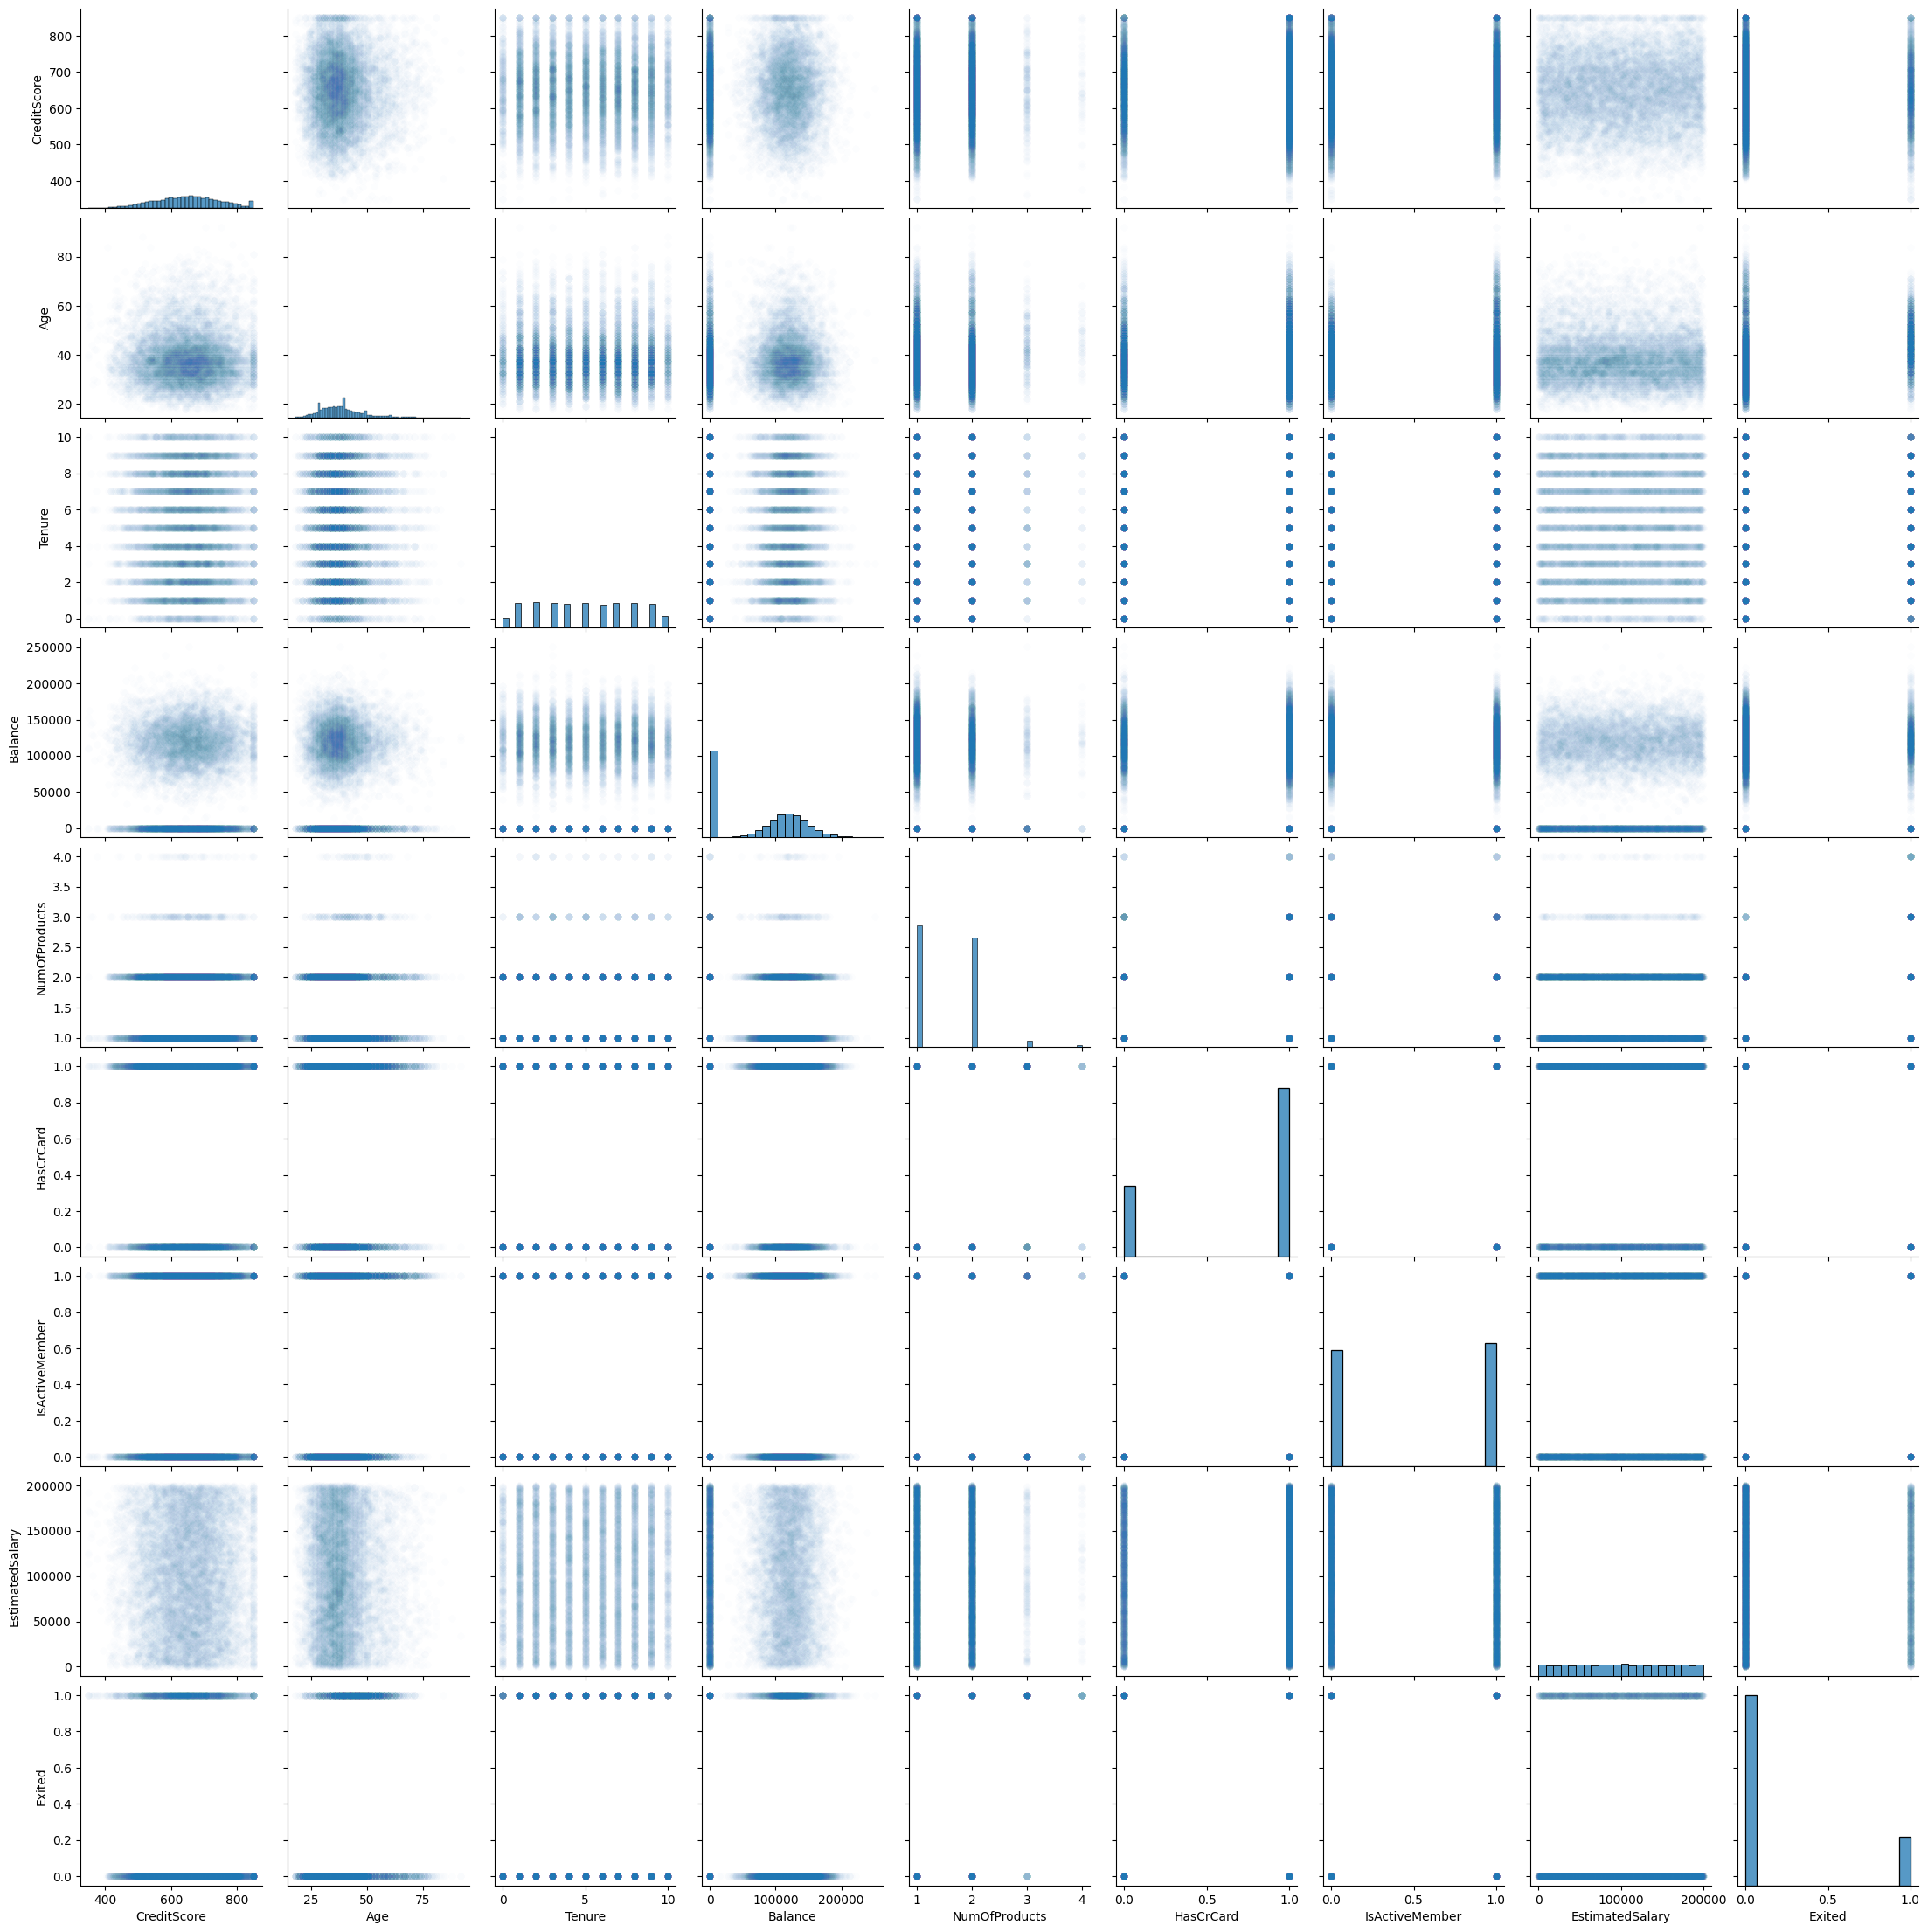

In [ ]:
sns.pairplot(data, kind='scatter', plot_kws={'alpha': 0.01})

In [8]:
# Convertimos los datos en formato categorico, para más info: shorturl.at/y0269
column_equivalence = {}
features = list(data.columns)
for i, column in enumerate(list([str(d) for d in data.dtypes])):
    if column == "object":
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].mode())
        categorical_column = data[data.columns[i]].astype("category")
        current_column_equivalence = dict(enumerate(categorical_column.cat.categories))
        column_equivalence[i] = dict((v,k) for k,v in current_column_equivalence.items())
        data[data.columns[i]] = categorical_column.cat.codes
    else:
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].median())

In [9]:
column_equivalence

{1: {'France': 0, 'Germany': 1, 'Spain': 2}, 2: {'Female': 0, 'Male': 1}}

# Vamos a crear un modelo de regresion logistica

In [10]:
# Generar los datos para poder separar la variable de respuesta de los datos que tenemos disponibles
X = data.copy()
y = X.pop(data.columns[-1])

In [11]:
# Separar los datos en datos de entrenamiento y testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
# Crear el modelo y entrenarlo
clf_lin =  LogisticRegression(random_state=0).fit(X, y)


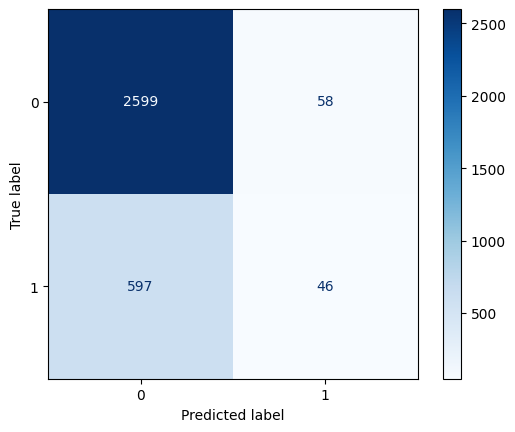

In [13]:
# Medir los resultados obtenidos
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, clf_lin.predict(X_test), labels=clf_lin.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=clf_lin.classes_)
disp.plot(cmap='Blues')



In [32]:
# Generar el binario del modelo para reutilizarlo, equivalencia de variables categoricas y caracteristicas del modelo
import pickle
pickle.dump(clf_lin, open("churn/models/model.pk", "wb"))
pickle.dump(column_equivalence, open("churn/models/column_equivalence.pk", "wb"))
pickle.dump(features, open("churn/models/features.pk", "wb"))

# Testing

### Undersampling con el target

In [ ]:
#Balanceamos los datos de forma random. Consideramos que tenemos una muestra suficientemente grande para hacerlo.
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(random_state=42)

In [77]:
under_random= RandomUnderSampler() 
X_us, y_us = under_random.fit_resample(data.drop('Exited', axis=1), data['Exited'])

under_df= pd.concat([pd.DataFrame(X_us), pd.DataFrame(y_us)], axis=1)
under_df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1880,589,Germany,Female,36,9,140355.56,2,1,0,136329.96,0
6907,519,France,Male,34,5,0.00,1,1,0,68479.60,0
2551,537,France,Female,53,3,0.00,1,1,1,91406.62,0
1816,531,France,Male,29,3,114590.58,1,0,0,75585.48,0
7784,741,France,Female,64,2,69311.16,1,1,1,59237.72,0
...,...,...,...,...,...,...,...,...,...,...,...
9981,498,Germany,Male,42,3,152039.70,1,1,1,53445.17,1
9982,655,Germany,Female,46,7,137145.12,1,1,0,115146.40,1
9991,597,France,Female,53,4,88381.21,1,1,0,69384.71,1
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1


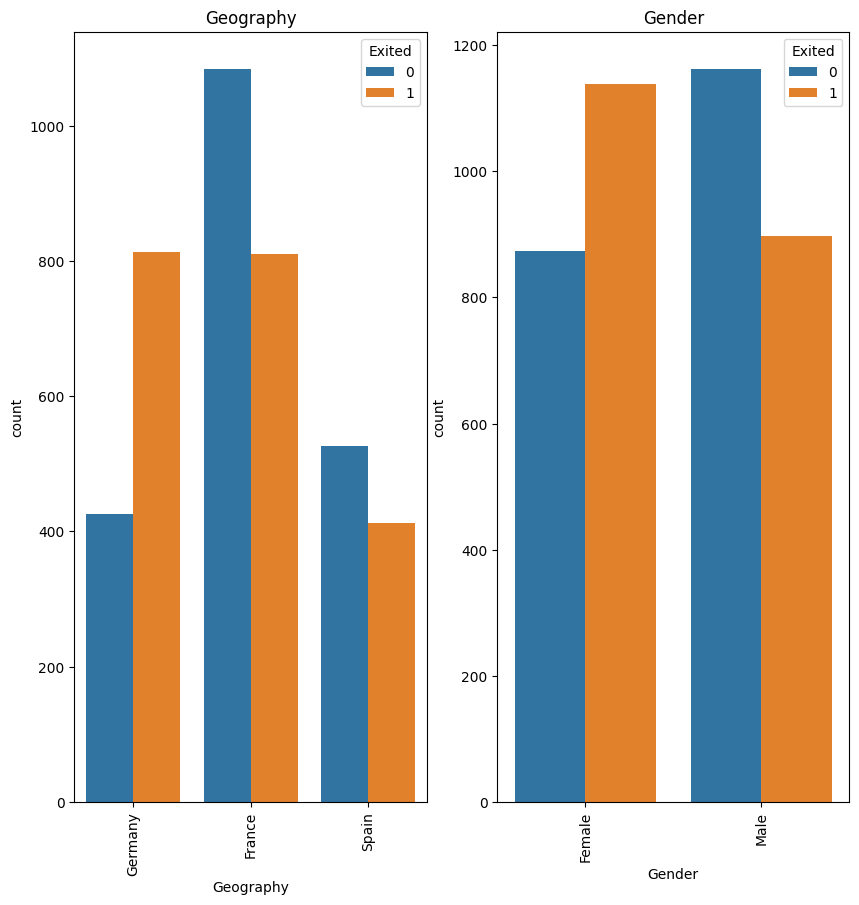

In [78]:
fig, ax = plt.subplots(figsize=(10, 10), ncols=len(cat_cols), nrows=1)
for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=under_df, ax=ax[i], hue='Exited')
    ax[i].set_title(col)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)

### Undersampling con País

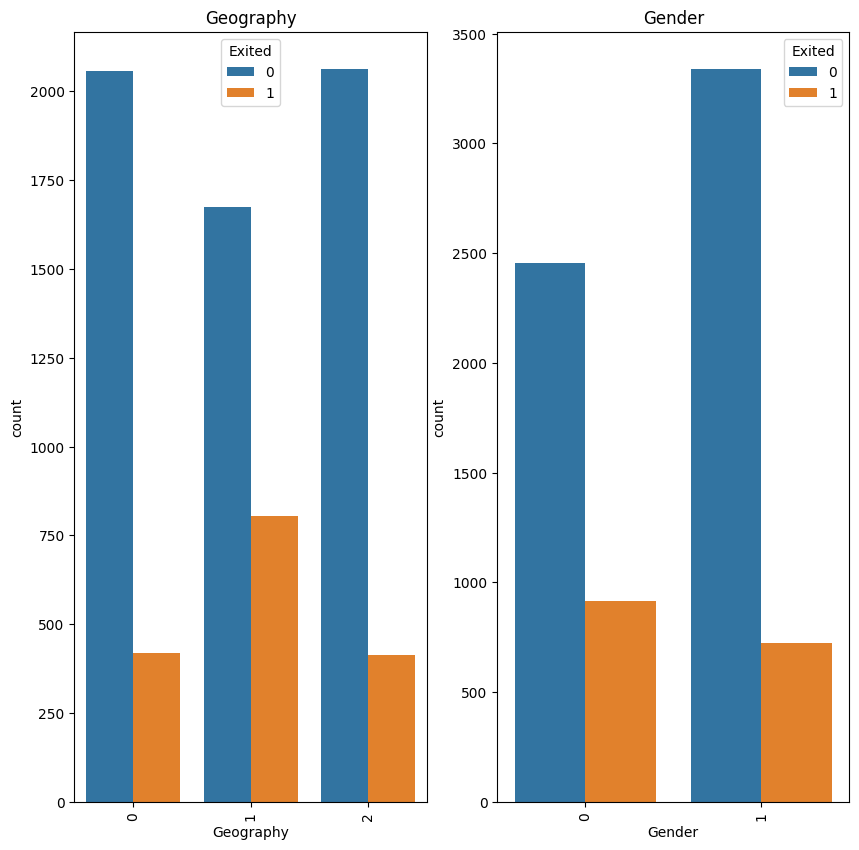

In [17]:
under_random= RandomUnderSampler()
X_us, y_us = under_random.fit_resample(data.drop('Geography', axis=1), data['Geography'])

under_df= pd.concat([pd.DataFrame(X_us), pd.DataFrame(y_us)], axis=1)
under_df

fig, ax = plt.subplots(figsize=(10, 10), ncols=len(cat_cols), nrows=1)
for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=under_df, ax=ax[i], hue='Exited')
    ax[i].set_title(col)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)

In [18]:
# Convertimos los datos en formato categorico, para más info: shorturl.at/y0269
column_equivalence = {}
features = list(under_df.columns)
for i, column in enumerate(list([str(d) for d in under_df.dtypes])):
    if column == "object":
        under_df[under_df.columns[i]] = under_df[under_df.columns[i]].fillna(under_df[under_df.columns[i]].mode())
        categorical_column = under_df[under_df.columns[i]].astype("category")
        current_column_equivalence = dict(enumerate(categorical_column.cat.categories))
        column_equivalence[i] = dict((v,k) for k,v in current_column_equivalence.items())
        under_df[under_df.columns[i]] = categorical_column.cat.codes
    else:
        under_df[under_df.columns[i]] = under_df[under_df.columns[i]].fillna(under_df[under_df.columns[i]].median())

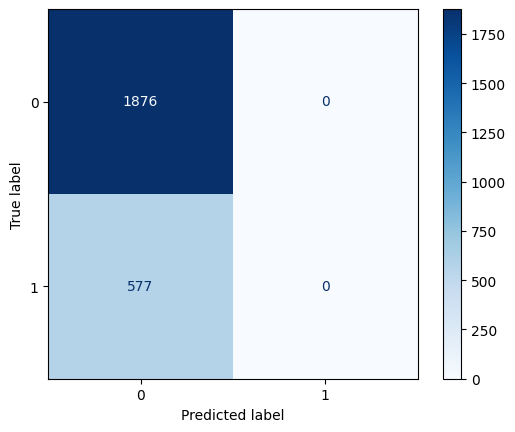

In [24]:
# Generar los datos para poder separar la variable de respuesta de los datos que tenemos disponibles
X = under_df[data.columns].copy()

y = X.pop(data.columns[-1])

# Separar los datos en datos de entrenamiento y testing
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

# Crear el modelo y entrenarlo
clf_lin =  LogisticRegression(random_state=0).fit(X, y)

# Medir los resultados obtenidos
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, clf_lin.predict(X_test), labels=clf_lin.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=clf_lin.classes_)
disp.plot(cmap='Blues')

### Onehot encoding y MinMaxScaler

In [8]:
# Importamos las librerías necesarias 

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler

In [6]:
# Copiamos el dataset original
data_df=data.copy()

# Separamos la variable de respuesta de los datos que tenemos disponibles
y = data_df.pop(data_df.columns[-1])

data_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [9]:
# Realizamos edl OneHotEncoder sobre las variables categóricas

categorical_columns = data_df.select_dtypes(object).columns

categorical_transformer = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    remainder="passthrough"
)

transformed_df = (
    pd.DataFrame(
        categorical_transformer.fit_transform(data_df),
        columns = categorical_transformer.get_feature_names_out(),
        index = data_df.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("onehotencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("remainder__")
    )
)

transformed_df

/home/pipe-vash/Personal_Projects/ml_lab/laboratorio-machine-learning/venv/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,1.0,0.0,0.0,1.0,0.0,619.0,42.0,2.0,0.00,1.0,1.0,1.0,101348.88
1,0.0,0.0,1.0,1.0,0.0,608.0,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58
2,1.0,0.0,0.0,1.0,0.0,502.0,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57
3,1.0,0.0,0.0,1.0,0.0,699.0,39.0,1.0,0.00,2.0,0.0,0.0,93826.63
4,0.0,0.0,1.0,1.0,0.0,850.0,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,0.0,0.0,0.0,1.0,771.0,39.0,5.0,0.00,2.0,1.0,0.0,96270.64
9996,1.0,0.0,0.0,0.0,1.0,516.0,35.0,10.0,57369.61,1.0,1.0,1.0,101699.77
9997,1.0,0.0,0.0,1.0,0.0,709.0,36.0,7.0,0.00,1.0,0.0,1.0,42085.58
9998,0.0,1.0,0.0,0.0,1.0,772.0,42.0,3.0,75075.31,2.0,1.0,0.0,92888.52


In [10]:
# Realizamos el MinMaxScaler para normalizar los datos

scaler=MinMaxScaler()
df_scaled=scaler.fit_transform(transformed_df)
df_scaled=pd.DataFrame(df_scaled,columns=transformed_df.columns)
df_scaled.head()

,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,1.0,0.0,0.0,1.0,0.0,0.538,0.324324,0.2,0.000000,0.000000,1.0,1.0,0.506735
1,0.0,0.0,1.0,1.0,0.0,0.516,0.310811,0.1,0.334031,0.000000,0.0,1.0,0.562709
2,1.0,0.0,0.0,1.0,0.0,0.304,0.324324,0.8,0.636357,0.666667,1.0,0.0,0.569654
3,1.0,0.0,0.0,1.0,0.0,0.698,0.283784,0.1,0.000000,0.333333,0.0,0.0,0.469120
4,0.0,0.0,1.0,1.0,0.0,1.000,0.337838,0.2,0.500246,0.000000,1.0,1.0,0.395400


In [11]:
import pickle
pickle.dump(categorical_transformer, open("churn/models/cat_trans.pk", "wb"))
pickle.dump(scaler, open("churn/models/scaler.pk", "wb"))
pickle.dump(data_df.columns, open("churn/models/df_features.pk", "wb"))

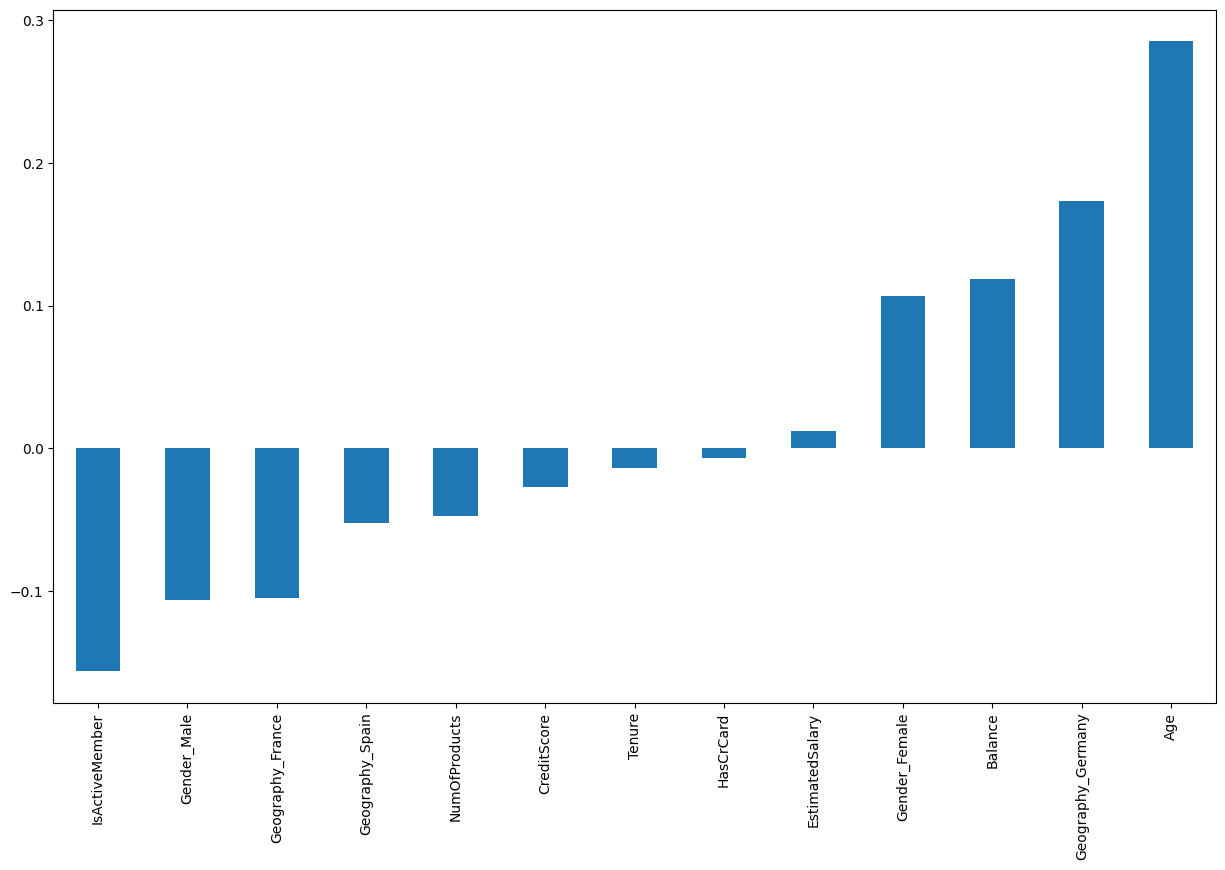

In [13]:
# Observamos la correlación de las variables con la variable objetivo

fig = plt.figure(figsize=(15,9))
transformed_df.corr()['Exited'].sort_values(ascending=True)[:-1].plot(kind='bar')
plt.show()

In [29]:
# Generar los datos para poder separar la variable de respuesta de los datos que tenemos disponibles
X = df_scaled.copy()

# Separar los datos en datos de entrenamiento y testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo y entrenarlo
clf_lin =  LogisticRegression().fit(X, y)

# Medir los resultados obtenidos
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, clf_lin.predict(X_test), labels=clf_lin.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=clf_lin.classes_)
disp.plot(cmap='Blues')



NameError: name 'df_scaled' is not defined

# Neural Networks

In [22]:
# Importamos las librerías necesarias

import numpy as np
from keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint

/home/pipe-vash/Personal_Projects/ml_lab/laboratorio-machine-learning/venv/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:205: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
/home/pipe-vash/Personal_Projects/ml_lab/laboratorio-machine-learning/venv/lib/python3.9/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:326: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


In [18]:
# Cuantificamos el número de features que tenemos en el dataset para ingresarlos al modelo.

n_features=len(X.columns)
n_features

13

In [55]:
# Inicializamos el modelo de la red neuronal

model = models.Sequential()
model.add(layers.Dense(n_features*2, activation= 'relu', input_shape=(n_features,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(n_features*2, activation= 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation= 'sigmoid'))

In [56]:
# Definimos el criterio de checkpoint para guardar el mejor modelo y compilamos la red.

checkpoint= ModelCheckpoint('churn/models/best_model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)


model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics='accuracy')

In [57]:
# Entrenamos la red neuronal separando el 25% de los datos para validación y guardamso el historial del entrenamiento.

history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_split=0.25,
                    callbacks=[checkpoint])

Epoch 1/50


185/188 [============================>.] - ETA: 0s - loss: 0.5171 - accuracy: 0.7921
Epoch 1: val_accuracy improved from -inf to 0.79500, saving model to churn/models/best_model.hdf5
188/188 [==============================] - 3s 14ms/step - loss: 0.5168 - accuracy: 0.7922 - val_loss: 0.4828 - val_accuracy: 0.7950
Epoch 2/50
185/188 [============================>.] - ETA: 0s - loss: 0.4894 - accuracy: 0.7953
Epoch 2: val_accuracy did not improve from 0.79500
188/188 [==============================] - 2s 13ms/step - loss: 0.4911 - accuracy: 0.7942 - val_loss: 0.4726 - val_accuracy: 0.7950
Epoch 3/50
188/188 [==============================] - ETA: 0s - loss: 0.4854 - accuracy: 0.7943
Epoch 3: val_accuracy did not improve from 0.79500
188/188 [==============================] - 2s 13ms/step - loss: 0.4854 - accuracy: 0.7943 - val_loss: 0.4633 - val_accuracy: 0.7950
Epoch 4/50
184/188 [============================>.] - ETA: 0s - loss: 0.4753 - accuracy: 0.7948
Epoch 4: val_accuracy did not i

In [58]:
# Preparamos variables para graficar los resultados del entrenamiento.

history_dict= history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

epochs = range(1,len(loss_values)+1)

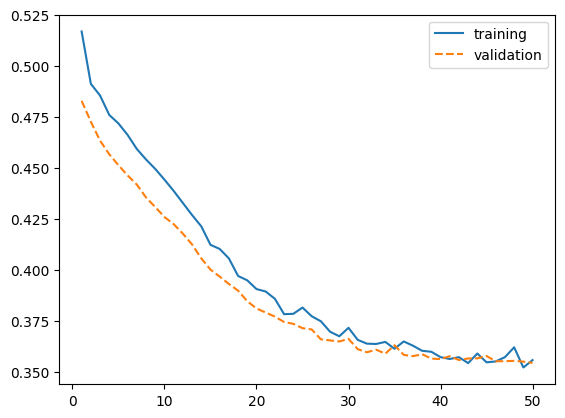

In [59]:
# Graficamos el Training Loss y el Validation Loss sobre cada época.

plt.plot(epochs,loss_values,'-',label = 'training')
plt.plot(epochs,val_loss_values,'--',label = 'validation')
plt.legend()
plt.show()

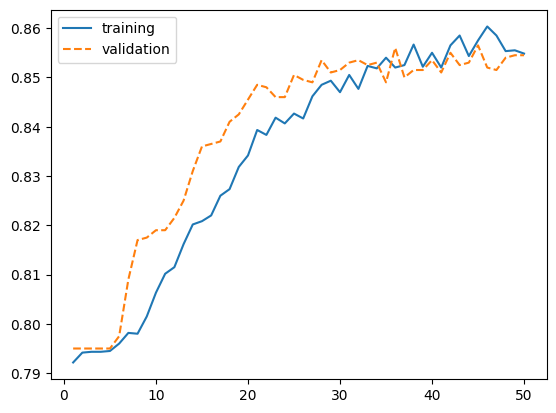

In [60]:
# Graficamos el Training Accuracy y el Validation Accuracy sobre cada época.


plt.plot(epochs,acc_values,'-',label = 'training')
plt.plot(epochs,val_acc_values,'--',label = 'validation')
plt.legend()
plt.show()

In [61]:
from keras.models import clone_model

best_model = clone_model(model)

best_model.load_weights('churn/models/best_model.hdf5')
best_model.compile(loss='binary_crossentropy',optimizer='rmsprop', metrics=['accuracy'])

In [62]:
y_pred_test = best_model.predict(X_test)

y_pred_labels = (y_pred_test > 0.5).astype(int).flatten()
print(y_pred_labels)


[0 0 0 ... 1 0 0]


In [63]:
y_test

6252    0.0
4684    0.0
1731    0.0
4742    0.0
4521    0.0
       ... 
6412    1.0
8285    0.0
7853    1.0
1095    1.0
6929    1.0
Name: Exited, Length: 2000, dtype: float64

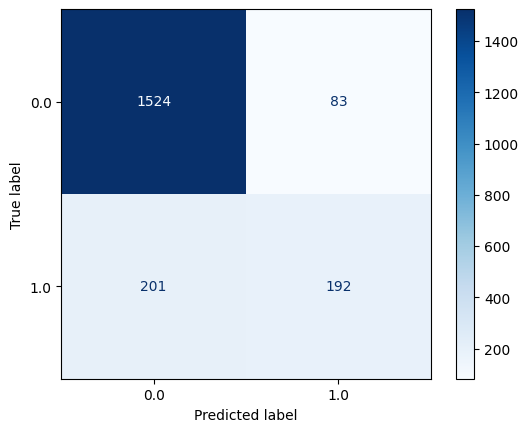

In [64]:
class_names = np.array([0., 1.])
cm = confusion_matrix(y_test, y_pred_labels, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.show()

# API Testing

In [2]:
feats= [465,'France','Female',51,8,122522.32,1,0,0,181297.65]

In [4]:
os.chdir('..')

In [5]:
import pickle
categorical_transformer = pickle.load(open("churn/models/cat_trans.pk", "rb"))
scaler = pickle.load(open("churn/models/scaler.pk", "rb"))
df_features = pickle.load(open("churn/models/df_features.pk", "rb"))

In [6]:
feats_df= pd.DataFrame([feats], columns= df_features)
feats_df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,465,France,Female,51,8,122522.32,1,0,0,181297.65


In [7]:
categorical_transformer.transform(feats_df)

array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 4.6500000e+02, 5.1000000e+01, 8.0000000e+00,
        1.2252232e+05, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.8129765e+05]])

In [11]:
final_df= scaler.transform(categorical_transformer.transform(feats_df))

/home/pipe-vash/Personal_Projects/ml_lab/laboratorio-machine-learning/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [10]:
from keras import models
test_model= models.load_model('churn/models/best_model.hdf5')

/home/pipe-vash/Personal_Projects/ml_lab/laboratorio-machine-learning/venv/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:205: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
/home/pipe-vash/Personal_Projects/ml_lab/laboratorio-machine-learning/venv/lib/python3.9/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:326: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
2023-08-17 17:31:07.214666: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-17 17:31:07.222594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-1

In [15]:
test_pred = test_model.predict(final_df)
test_pred

array([[0.6651235]], dtype=float32)

In [21]:
test_pred_labels = (test_pred > 0.5).astype(int).flatten()
print(test_pred_labels)


[1]


In [22]:
type(test_pred_labels)

numpy.ndarray

In [23]:
test_pred_labels.tolist()

[1]